<a href="https://colab.research.google.com/github/nirjalalala/learn_ml/blob/main/Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**CONCRETE DATA**

Data from - https://www.kaggle.com/datasets/elikplim/concrete-compressive-strength-data-set/data

###**Objective**:
---
<br> To perform EDA and fit a linear regression model that predicts concrete-compression-strength based on various other features.

---

In [25]:
#importing libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR

from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import r2_score, mean_squared_error


In [2]:
#Loading the dataset
df = pd.read_csv('/content/drive/MyDrive/concrete_data.csv')

#Printing first 5 rows
df.head()

,cement,blast_furnace_slag,fly_ash,water,superplasticizer,coarse_aggregate,fine_aggregate,age,concrete_compressive_strength
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28,79.99
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28,61.89
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,270,40.27
3,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365,41.05
4,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360,44.30


##EXPLORATORY DATA ANALYSIS

In [ ]:
#Checking datatypes and null values in the columns of our dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1030 entries, 0 to 1029
Data columns (total 9 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   cement                         1030 non-null   float64
 1   blast_furnace_slag             1030 non-null   float64
 2   fly_ash                        1030 non-null   float64
 3   water                          1030 non-null   float64
 4   superplasticizer               1030 non-null   float64
 5   coarse_aggregate               1030 non-null   float64
 6   fine_aggregate                 1030 non-null   float64
 7   age                            1030 non-null   int64  
 8   concrete_compressive_strength  1030 non-null   float64
dtypes: float64(8), int64(1)
memory usage: 72.6 KB




*   There are 9 colums and 1030 total rows.
*   There are no missing values.
*   All columns are numeric.



In [ ]:
#Statistical measures of all column
df.describe()

,cement,blast_furnace_slag,fly_ash,water,superplasticizer,coarse_aggregate,fine_aggregate,age,concrete_compressive_strength
count,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000
mean,281.167864,73.895825,54.188350,181.567282,6.204660,972.918932,773.580485,45.662136,35.817961
std,104.506364,86.279342,63.997004,21.354219,5.973841,77.753954,80.175980,63.169912,16.705742
min,102.000000,0.000000,0.000000,121.800000,0.000000,801.000000,594.000000,1.000000,2.330000
25%,192.375000,0.000000,0.000000,164.900000,0.000000,932.000000,730.950000,7.000000,23.710000
50%,272.900000,22.000000,0.000000,185.000000,6.400000,968.000000,779.500000,28.000000,34.445000
75%,350.000000,142.950000,118.300000,192.000000,10.200000,1029.400000,824.000000,56.000000,46.135000
max,540.000000,359.400000,200.100000,247.000000,32.200000,1145.000000,992.600000,365.000000,82.600000


In [ ]:
#Correlation among the variables
corr = df.corr()

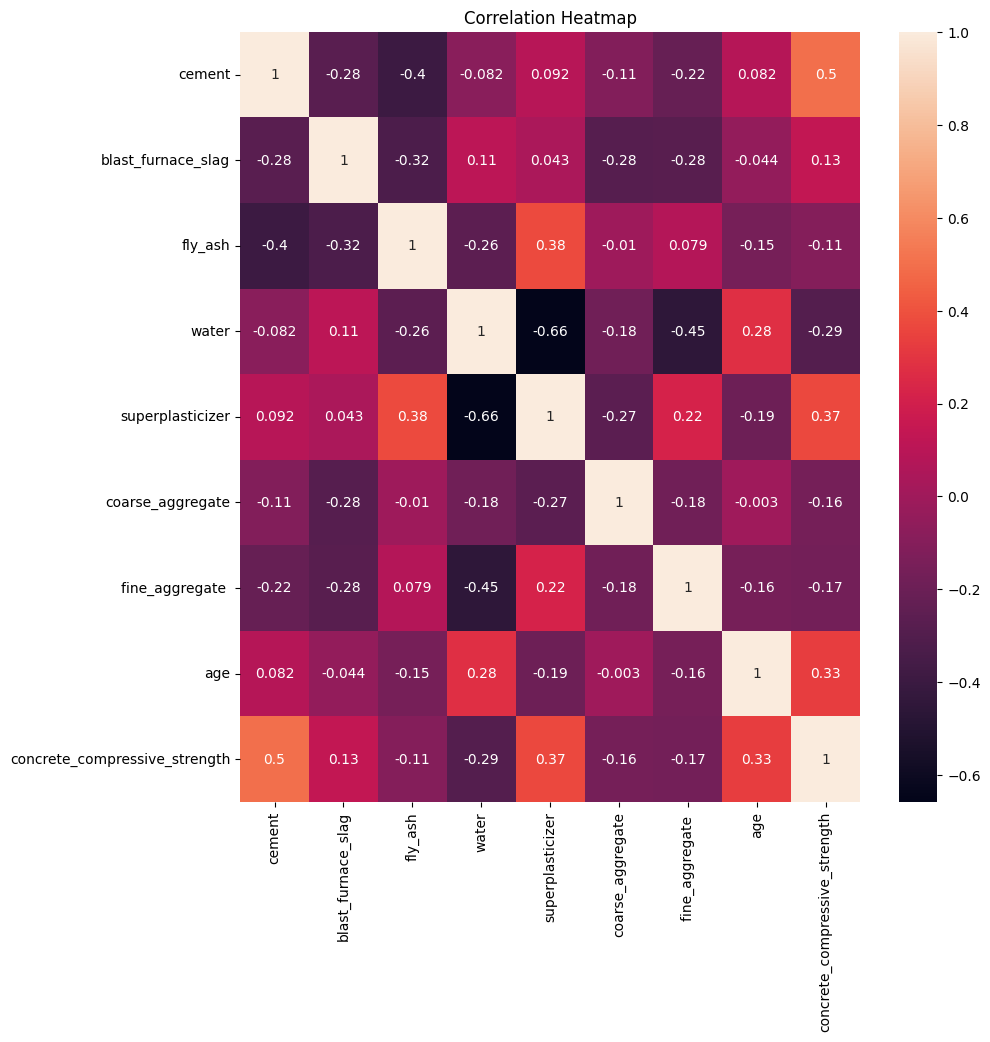

In [ ]:
#Visualizing the correlation using a heat map

plt.figure(figsize=(10,10))
sns.heatmap(corr, annot=True)
plt.title("Correlation Heatmap")
plt.show()

We can also find the correlation of our target variable with the predicting variables.

In [ ]:
#Correlation of 'concrete_compressive_strength' with remaining variables

corr['concrete_compressive_strength'].sort_values(ascending=False)

,concrete_compressive_strength
concrete_compressive_strength,1.000000
cement,0.497832
superplasticizer,0.366079
age,0.328873
blast_furnace_slag,0.134829
fly_ash,-0.105755
coarse_aggregate,-0.164935
fine_aggregate,-0.167241
water,-0.289633


We can see that, 'concrete_compressive_strength' has:
*  moderate positive correlation with features like 'cement' , 'superplasticizer', 'age' and 'blast_furnace_slag'.
* weak negative correlation with features like 'water', 'fine_aggregate', 'coarse_aggregate' and 'fly_ash'.
* Highest correlation is with 'cement' while the lowest correlation is with 'fly_ash'.

,0
cement,"Axes(0.125,0.653529;0.227941x0.226471)"
blast_furnace_slag,"Axes(0.398529,0.653529;0.227941x0.226471)"
fly_ash,"Axes(0.672059,0.653529;0.227941x0.226471)"
water,"Axes(0.125,0.381765;0.227941x0.226471)"
superplasticizer,"Axes(0.398529,0.381765;0.227941x0.226471)"
coarse_aggregate,"Axes(0.672059,0.381765;0.227941x0.226471)"
fine_aggregate,"Axes(0.125,0.11;0.227941x0.226471)"
age,"Axes(0.398529,0.11;0.227941x0.226471)"
concrete_compressive_strength,"Axes(0.672059,0.11;0.227941x0.226471)"


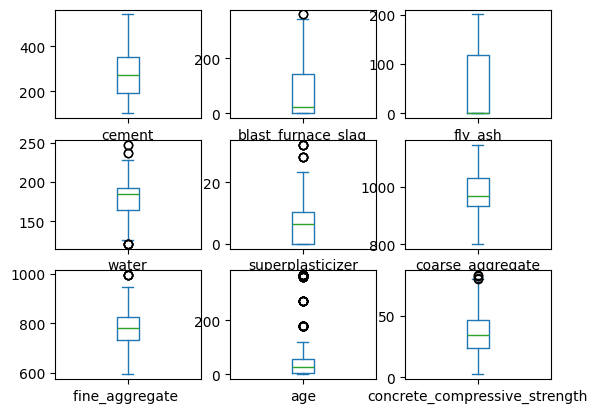

In [ ]:
df.plot(kind='box', subplots=True, layout=(3,3), sharex=False, sharey=False)

Looks like there are no outliers in our colums.
We can see some outliers in 'age' column.

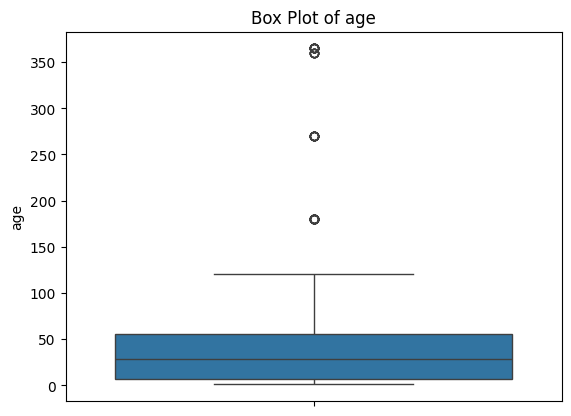

In [ ]:
#Box plot for 'age' column

sns.boxplot(df['age'])
plt.title("Box Plot of age")
plt.show()


In [ ]:
df.shape

(1030, 9)

Since we have a very large dataset, we donot drop these outlier values.

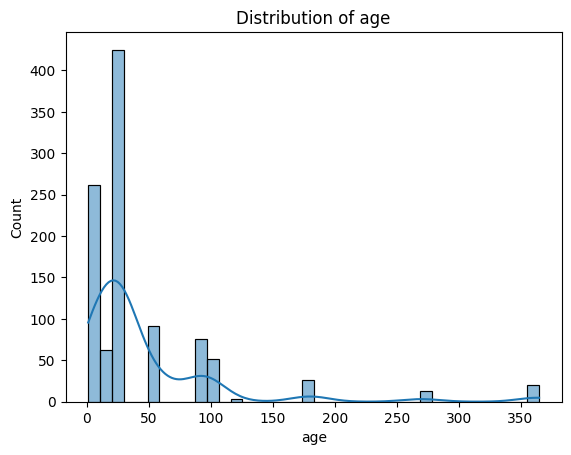

In [ ]:
#Distribution of 'age' variable

sns.histplot(df['age'],kde=True)
plt.title("Distribution of age")
plt.show()

The distribution is right-skewed.

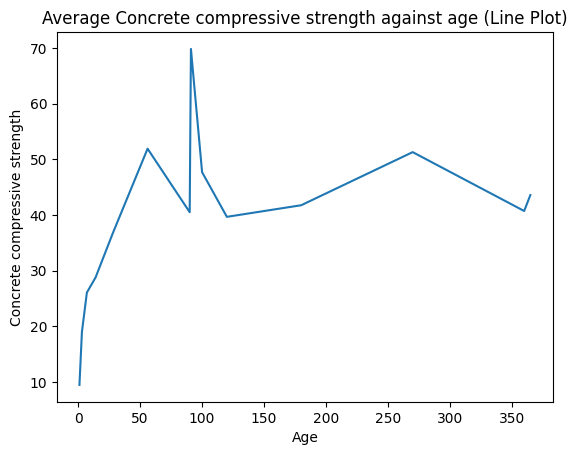

In [ ]:
# To use a line plot, group by age and calculate the mean
age_strength_mean = df.groupby('age')['concrete_compressive_strength'].mean().reset_index()

sns.lineplot(x='age', y='concrete_compressive_strength', data=age_strength_mean)
plt.title("Average Concrete compressive strength against age (Line Plot)")
plt.xlabel("Age")
plt.ylabel("Concrete compressive strength")
plt.show()

This shows how the average concrete compressive strength changes as age increases. The maximum average strength is seen at age 100 days.

##BUILDING THE MODELS

In [17]:
#Load our X features and y label
X = df.drop('concrete_compressive_strength',axis=1).values
y = df['concrete_compressive_strength'].values

#Split our data as training data and testing data
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=17)


In [18]:
#Scaling the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

We'll try these various models:
* Linear Regression
* Ridge Regression
* Decision Tree Regression
* Random Forest Regression
* Support Vector Regression

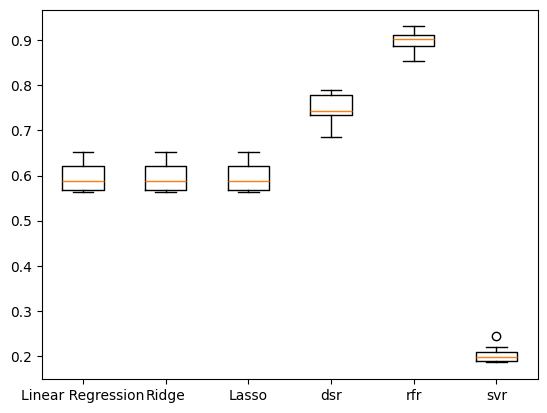

In [41]:
models = {
    "Linear Regression": LinearRegression(),
    "Ridge": Ridge(alpha=0.1),
    "Lasso": Lasso(alpha=0.1),
    "dsr": DecisionTreeRegressor(max_depth=5,min_samples_split=5),
    "rfr": RandomForestRegressor(n_estimators=50, max_depth=10, min_samples_split=5),
    "svr": SVR()
    }
#
results = []


kf = KFold(n_splits=7, random_state=42, shuffle=True)

# Loop through the models' values
for model in models.values():

  # Perform cross-validation
  cv_scores = cross_val_score(model, X_train, y_train, cv=kf)

  # Append the results
  results.append(cv_scores)

# Create a box plot of the results
plt.boxplot(results, tick_labels=models.keys())
plt.show()

In [37]:
test_mse = {}
for name, model in models.items():

  # Fit the model to the training data
  model.fit(X_train_scaled,y_train)

  # Make predictions on the test set
  y_pred = model.predict(X_test_scaled)

  # Calculate the test_rmse
  test_mse[name] = mean_squared_error(y_test, y_pred)
  print(f"{name} Test Set MSE: {test_mse[name]}")

Linear Regression Test Set MSE: 84.9743926562672
Ridge Test Set MSE: 84.9609511557895
Lasso Test Set MSE: 84.43802823604987
dsr Test Set MSE: 68.16861800047118
rfr Test Set MSE: 24.762281347756833
svr Test Set MSE: 83.26559957021628


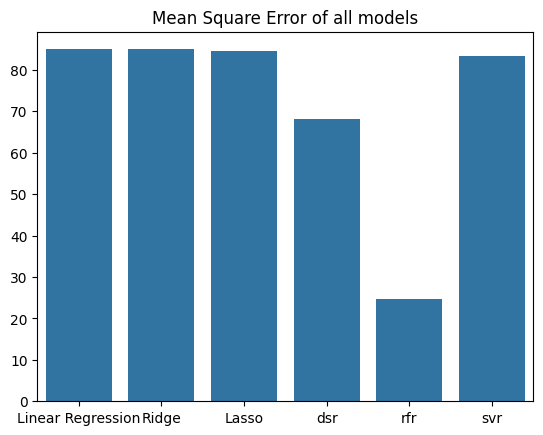

In [40]:
#bar graph to show mse of all models

sns.barplot(x=list(models.keys()), y=test_mse.values())
plt.title("Mean Square Error of all models")
plt.show()

From above two figures, we conclude that the rfr (random forest regresser) model has the least errors and highest cross validation scores.

##HYPERTUNING THE PARAMETERS OF SELECTED MODEL

The model we will be tuning is RandomForestRegression model.

In [ ]:
# Import GridSearchCV
from sklearn.model_selection import GridSearchCV

# Set up the parameter grid
param_grid = {
              "n_estimators":[50,100,150,200],
              "max_depth":[None, 10, 20],
              "min_samples_split":[2,4,6]
              }

#Create the model
rfr = RandomForestRegressor(random_state=42)

#Create a KFold object
kf = KFold(n_splits=7, random_state=42, shuffle=True)

# Instantiate rfr_cv
rfr_cv = GridSearchCV(rfr, param_grid, cv=kf)

# Fit to the training data
rfr_cv.fit(X_train, y_train)


In [45]:
#Printing the tuned parameters and validation score
print("Tuned paramaters: {}".format(rfr_cv.best_params_))
print("Tuned score: {}".format(rfr_cv.best_score_))

Tuned paramaters: {'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 150}
Tuned score: 0.9085558359909623


In [56]:
#Get the tuned model
regression_model = rfr_cv.best_estimator_

In [57]:
regression_model

RandomForestRegressor(max_depth=20, n_estimators=150, random_state=42)

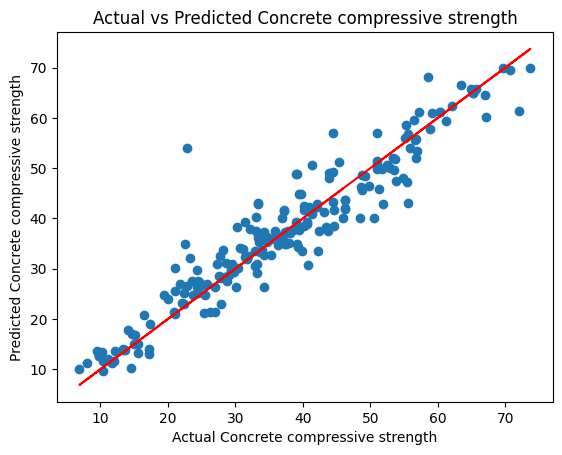

In [58]:
#Make predictions on the test data using the tuned model
y_pred_tuned = regression_model.predict(X_test)

#Visualize the model prediction using scatter-plot
plt.scatter(y_test, y_pred_tuned)
plt.xlabel("Actual Concrete compressive strength")
plt.ylabel("Predicted Concrete compressive strength")
plt.plot(y_test,y_test, color='red')
plt.title("Actual vs Predicted Concrete compressive strength")
plt.show()

In [59]:
mse_tuned = mean_squared_error(y_test, y_pred_tuned)
rmse_tuned = np.sqrt(mse_tuned) # Calculate RMSE
r2_tuned = r2_score(y_test, y_pred_tuned)

print(f"Tuned Random Forest Regressor Test Set MSE: {mse_tuned}")
print(f"Tuned Random Forest Regressor Test Set RMSE: {rmse_tuned}")
print(f"Tuned Random Forest Regressor Test Set R-squared: {r2_tuned}")

Tuned Random Forest Regressor Test Set MSE: 22.640489185206313
Tuned Random Forest Regressor Test Set RMSE: 4.758202306040204
Tuned Random Forest Regressor Test Set R-squared: 0.9031712619415254


###**SAVING THE MODEL**

In [60]:
import joblib

joblib.dump(regression_model, 'random_forest_model.pkl')
joblib.dump(scaler, 'scaler.pkl')

['scaler.pkl']

#**Concrete Compressive Strength Prediction - Model Training Summary**
---
**Objective:** To train a regression model to predict concrete compressive strength based on various material properties and age.

---

**Data:** The model was trained on the Concrete Compressive Strength dataset.

---

**Methodology:**

---
* **Data Preparation**: The dataset was loaded and explored. Key steps included checking data types, identifying missing values (none found), and examining descriptive statistics and correlations. The data was split into training and testing sets (80/20 split).
* **Feature Scaling**: Features were scaled using StandardScaler to ensure that no single feature dominated the model due to differences in scale.
* **Model Selection**: Several regression models were initially evaluated using cross-validation on the training set: Linear Regression, Ridge Regression, Lasso Regression, Decision Tree Regression, Random Forest Regression, and Support Vector Regression.
* **Model Performance Evaluation (Initial)**: The Mean Squared Error (MSE) and cross-validation scores were used to compare the initial performance of the models. Random Forest Regression showed promising performance based on these initial assessments.
* **Hyperparameter Tuning**: The Random Forest Regressor model, identified as a strong candidate, was selected for hyperparameter tuning using GridSearchCV with 7-fold cross-validation. The parameters tuned included n_estimators, max_depth, and min_samples_split.
* **Tuned Model Evaluation**: The tuned Random Forest Regressor model was evaluated on the independent test set to assess its generalization performance.

---
**Results:**

---
* The GridSearchCV identified the optimal hyperparameters for the Random Forest Regressor within the defined search space.
* The tuned Random Forest Regressor model achieved the following performance metrics on the test set:
1. Mean Squared Error (MSE): 22.640489185206313
2. Root Mean Squared Error (RMSE): 4.758202306040204
3. R-squared (R²):  0.9031712619415254

---
**Conclusion:**

---

The model training and tuning process for predicting concrete compressive strength is complete. A Random Forest Regressor model has been trained and tuned, and its performance on the independent test set has been evaluated. The obtained metrics provide an indication of the model's ability to predict concrete strength on unseen data.

---
**Next Steps:**

---

* Further analysis of model predictions and potential areas for improvement (e.g., feature engineering, exploring other models).
* Deployment of the trained model for making predictions on new concrete data.
